In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from collections import defaultdict
import pickle
from torch.autograd import Variable
import torch.optim as optim
%matplotlib inline

In [2]:
train_foldername = 'en-valid-10k'
train_filename = 'qa1_train.txt'
train_fname = './bAbI_Data/'+str(train_foldername)+'/'+str(train_filename)

valid_foldername = 'en-valid-10k'
valid_filename = 'qa1_valid.txt'
valid_fname = './bAbI_Data/'+str(valid_foldername)+'/'+str(valid_filename)

In [3]:
train_dat_aux = []
valid_dat_aux = []
punctuations = ['.',',','?']

for l in open(train_fname):
    temp = ''.join(ch for ch in l if ch not in punctuations)
    train_dat_aux.append(temp.strip().split())
    
for l in open(valid_fname):
    temp = ''.join(ch for ch in l if ch not in punctuations)
    valid_dat_aux.append(temp.strip().split())

print(len(train_dat_aux))
print(len(valid_dat_aux))

27000
3000


In [4]:
def hasDigits(input_str):
    return any(char.isdigit() for char in input_str)

In [5]:
def create_vocab(data,unk_thres=0):
    aux = defaultdict(int)
    for i in range(len(data)):
        for j in range(1,len(data[i])):
            if hasDigits(data[i][j]):
                break
            aux[data[i][j]] += 1
    vocab = []
    unk_list = []
    for i in aux:
        if aux[i] < unk_thres:
            if not unk_list:
                vocab.append('UNK')
            unk_list.append(i)
        else:
            vocab.append(i)
    
    return vocab, unk_list

In [6]:
def create_dictionaries(vocab):
    word2idx = defaultdict(int)
    idx2word = defaultdict(int)
    k = 0
    for i in range(len(vocab)):
        word2idx[vocab[i]] = k
        idx2word[k] = vocab[i]
        k += 1
    
    with open('variables/word2idx','wb') as handle:
        pickle.dump(word2idx,handle,protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('variables/idx2word','wb') as handle:
        pickle.dump(idx2word,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
vocab, unk_list = create_vocab(train_dat_aux,0)
#create_dictionaries(vocab)

In [8]:
with open('variables/word2idx','rb') as handle:
    word2idx = pickle.load(handle)

with open('variables/idx2word','rb') as handle:
    idx2word = pickle.load(handle)

In [9]:
def transform_data_BOW(data,vocab,unk_list,word2idx):
    N = len(vocab)
    dat_trans = np.zeros((len(data),N+1))
    for i in range(len(data)):
        if hasDigits(data[i][-1]):
            dat_trans[i,N] = word2idx[data[i][-2]]
            for j in range(1,len(data[i])-2):
                if data[i][j] in unk_list:
                    dat_trans[i,word2idx['UNK']] += 1
                else:
                    dat_trans[i,word2idx[data[i][j]]] += 1
        else:
            if data[i][0] == '1':
                dat_trans[i,N] = -2
            else:
                dat_trans[i,N] = -1
            for j in range(1,len(data[i])):
                #print(data[i][j],unk_list)
                if data[i][j] in unk_list:
                    dat_trans[i,word2idx['UNK']] += 1
                else:
                    dat_trans[i,word2idx[data[i][j]]] += 1
    
    return dat_trans

In [10]:
train_data = transform_data_BOW(train_dat_aux,vocab,unk_list,word2idx)
valid_data = transform_data_BOW(valid_dat_aux,vocab,unk_list,word2idx)

In [11]:
def smax(x):
    y = torch.div(torch.exp(x),torch.sum(torch.exp(x)))
    return y

In [12]:
def comp(out,target):
    if (target.data[0] == np.argmax(smax(out.data))):
        return 1
    else:
        return 0

In [13]:
class QuesAnsModel(torch.nn.Module):
    def __init__(self,embedding_dim, vocab_size, num_hops = 1, max_mem_size=15, temporal=False):
        super(QuesAnsModel,self).__init__()
        self.max_mem_size = max_mem_size
        self.vocab_size = vocab_size
        self.num_hops = num_hops
        self.embedding_dim = embedding_dim
        self.memory = Variable(torch.zeros((max_mem_size, vocab_size)).float())
        self.temporal = temporal
#         self.memory = Variable(torch.zeros((max_mem_size, vocab_size)).float().cuda())
        self.current_mem_size = 0
        self.embedding_A = torch.nn.Linear(self.vocab_size,self.embedding_dim,bias=False)
        self.embedding_B = torch.nn.Linear(self.vocab_size,self.embedding_dim,bias=False)
        self.embedding_C = torch.nn.Linear(self.vocab_size,self.embedding_dim,bias=False)
        
        self.temporal_A = torch.nn.Parameter(torch.randn(self.max_mem_size,self.embedding_dim).float())
        self.temporal_C = torch.nn.Parameter(torch.randn(self.max_mem_size,self.embedding_dim).float())
        
        self.W = torch.nn.Linear(self.embedding_dim,self.vocab_size,bias=False)
#         self.embedding_A = torch.nn.Linear(self.vocab_size,self.embedding_dim,bias=False).cuda()
#         self.embedding_B = torch.nn.Linear(self.vocab_size,self.embedding_dim,bias=False).cuda()
#         self.embedding_C = torch.nn.Linear(self.vocab_size,self.embedding_dim,bias=False).cuda()
#         self.W = torch.nn.Linear(self.embedding_dim,self.vocab_size,bias=False).cuda()
        torch.nn.init.xavier_normal(self.embedding_A.weight)
        torch.nn.init.xavier_normal(self.embedding_B.weight)
        torch.nn.init.xavier_normal(self.embedding_C.weight)
        torch.nn.init.xavier_normal(self.W.weight)
        self.softmax = torch.nn.Softmax()
    def forward(self, seq, tag):
        if tag == 's':
            if self.curr_mem_size < self.max_mem_size:
                self.memory[self.curr_mem_size] = Variable(torch.from_numpy(seq).float()).view(1,-1)
#                 self.memory[self.curr_mem_size] = Variable(torch.from_numpy(seq).float().cuda()).view(1,-1)
                self.curr_mem_size+=1
            else:
                pass
            return True
        elif tag == 'f':
            del self.memory
            self.curr_mem_size=0
            self.memory = Variable(torch.from_numpy(np.zeros((self.max_mem_size, self.vocab_size))).float())
            self.memory[0] = Variable(torch.from_numpy(seq).float()).view(1,-1)
#             self.memory = Variable(torch.from_numpy(np.zeros((self.max_mem_size, self.vocab_size))).float().cuda())
#             self.memory[0] = Variable(torch.from_numpy(seq).float().cuda()).view(1,-1)
            return True
        elif tag == 'q':
            if self.temporal == True:
                temp_mem = np.flipud(np.array(self.memory.data))
                self.memory = Variable(torch.from_numpy(temp_mem.copy())).float()

                self.question = Variable(torch.from_numpy(seq).float()).view(1,-1)

                ques_d = self.embedding_B(self.question)
                current_A = self.embedding_A(self.memory) + self.temporal_A
                current_C = self.embedding_C(self.memory) + self.temporal_C
            else:
                self.question = Variable(torch.from_numpy(seq).float()).view(1,-1)
    #             self.question = Variable(torch.from_numpy(seq).float().cuda()).view(1,-1)
                ques_d = self.embedding_B(self.question)
                current_A = self.embedding_A(self.memory)
                current_C = self.embedding_C(self.memory)
            for i in range(self.num_hops):
                P = self.softmax(torch.mm(ques_d, current_A.t()).t())
                o = torch.mm(P.t(),current_C) + ques_d
                ques_d = o
            output = self.W(o)
            return output

In [14]:
def train(model,tr_dt,vd_dt,epochs=10,eta=0.001):
#     tr_dt = torch.from_numpy(np.array(tr_data))
    optimizer = optim.Adam(model.parameters(),lr=eta)
    loss = torch.nn.CrossEntropyLoss()
    tr_shape = tr_dt.shape
    vd_shape = vd_dt.shape
    eps = []
    l_tr = []
    l_vd = []
    accuracy_tr = []
    accuracy_vd = []
    for epoch in range(epochs):
        count=0;
        ################################# Training
        n_corr = 0;
        for i in range(tr_shape[0]):
            l_temp = 0
            tag = 'q'
            if(tr_dt[i,-1]==-1):
                tag = 's'
                model(tr_dt[i,:-1],tag)
            elif(tr_dt[i,-1]==-2):
                tag = 'f'
                model(tr_dt[i,:-1],tag)
            else:
                count+=1
                out = model(tr_dt[i,:-1],tag)
#                 print(out)
                target = Variable(torch.from_numpy(np.array([tr_dt[i,-1]])).type(torch.LongTensor))
#                 target = Variable(torch.from_numpy(np.array([tr_dt[i,-1]])).type(torch.LongTensor).cuda())
                optimizer.zero_grad()
                loss_tr = loss(out,target)
                loss_tr.backward(retain_graph=True)
                optimizer.step()
                l_temp += loss_tr.data[0]
#                 if i % 15 == 14:
#                     print('[%d, %5d] loss: %.3f' % (epoch+1,i+1,l_temp/15))
#                 print('sds', out, target)
                n_corr += comp(out,target)
        acc_tr = n_corr/count*100
        l_tr.append(l_temp)
        accuracy_tr.append(acc_tr)
        
        ############################# Validation
        n_corr = 0;
        count = 0;
        for i in range(vd_shape[0]):
            l_temp = 0
            tag = 'q'
            if(vd_dt[i,-1]==-1):
                tag = 's'
                model(vd_dt[i,:-1],tag)
            elif(vd_dt[i,-1]==-2):
                tag = 'f'
                model(vd_dt[i,:-1],tag)
            else:
                count+=1
                out = model(vd_dt[i,:-1],tag)
                target = Variable(torch.from_numpy(np.array([vd_dt[i,-1]])).type(torch.LongTensor))
#                 target = Variable(torch.from_numpy(np.array([vd_dt[i,-1]])).type(torch.LongTensor).cuda())
                optimizer.zero_grad()
                loss_vd = loss(out,target)
                l_temp += loss_vd.data[0]
                n_corr += comp(out,target)
        acc_vd = n_corr/count*100
        l_vd.append(l_temp)
        accuracy_vd.append(acc_vd)
        
        eps.append(epoch)
        print(epoch,'Training Loss : ',l_tr[-1],' , Training Acc : ',accuracy_tr[-1])
        print(epoch,'Validation Loss : ',l_vd[-1],' , Validation Acc : ',accuracy_vd[-1])
        
    plt.plot(eps,l_tr)
    plt.plot(eps,l_vd)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss','Validation Loss'])
    plt.savefig('Loss1.png')
    plt.show()

    plt.plot(eps,accuracy_tr)
    plt.plot(eps,accuracy_vd)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy%')
    plt.legend(['Training Accuracy','Validation Accuracy'],loc=4)
    plt.savefig('Acc1.png')
    plt.show()
    return l_tr, accuracy_tr, l_vd, accuracy_vd

/home/roshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 Training Loss :  3.697492837905884  , Training Acc :  33.55555555555556
0 Validation Loss :  1.2336268424987793  , Validation Acc :  37.6
1 Training Loss :  3.237393617630005  , Training Acc :  36.94444444444444
1 Validation Loss :  1.4532991647720337  , Validation Acc :  40.0
2 Training Loss :  2.9328556060791016  , Training Acc :  39.044444444444444
2 Validation Loss :  1.420897364616394  , Validation Acc :  40.400000000000006
3 Training Loss :  2.54367995262146  , Training Acc :  40.6
3 Validation Loss :  1.5085177421569824  , Validation Acc :  42.199999999999996
4 Training Loss :  2.2118773460388184  , Training Acc :  41.733333333333334
4 Validation Loss :  1.680433750152588  , Validation Acc :  43.6
5 Training Loss :  1.9906320571899414  , Training Acc :  42.611111111111114
5 Validation Loss :  1.8861912488937378  , Validation Acc :  44.9
6 Training Loss :  1.829459309577942  , Training Acc :  43.022222222222226
6 Validation Loss :  2.009350061416626  , Validation Acc :  45.1
7 

58 Training Loss :  1.560552954673767  , Training Acc :  43.1
58 Validation Loss :  2.237424850463867  , Validation Acc :  45.800000000000004
59 Training Loss :  1.5646899938583374  , Training Acc :  43.27777777777778
59 Validation Loss :  2.278585910797119  , Validation Acc :  45.800000000000004
60 Training Loss :  1.5479789972305298  , Training Acc :  43.266666666666666
60 Validation Loss :  2.268263816833496  , Validation Acc :  45.800000000000004
61 Training Loss :  1.5531005859375  , Training Acc :  43.15555555555556
61 Validation Loss :  2.275082588195801  , Validation Acc :  46.400000000000006
62 Training Loss :  1.5486048460006714  , Training Acc :  43.08888888888889
62 Validation Loss :  2.2557618618011475  , Validation Acc :  45.7
63 Training Loss :  1.6022517681121826  , Training Acc :  43.21111111111111
63 Validation Loss :  2.2344791889190674  , Validation Acc :  45.800000000000004
64 Training Loss :  1.620290756225586  , Training Acc :  43.2
64 Validation Loss :  2.215650

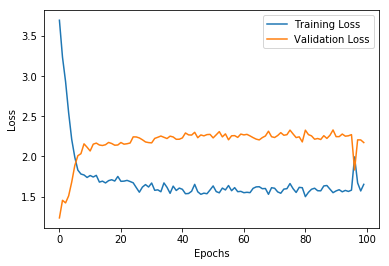

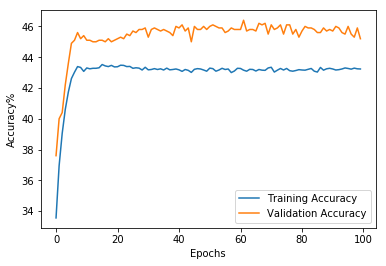

([3.697492837905884,
  3.237393617630005,
  2.9328556060791016,
  2.54367995262146,
  2.2118773460388184,
  1.9906320571899414,
  1.829459309577942,
  1.7805640697479248,
  1.7689129114151,
  1.7378780841827393,
  1.762170433998108,
  1.74351167678833,
  1.7640351057052612,
  1.6800812482833862,
  1.6918641328811646,
  1.6697514057159424,
  1.6983826160430908,
  1.70952308177948,
  1.6932506561279297,
  1.7505606412887573,
  1.6897625923156738,
  1.692043423652649,
  1.701410174369812,
  1.6873377561569214,
  1.6711180210113525,
  1.6116441488265991,
  1.5540034770965576,
  1.6179465055465698,
  1.6489849090576172,
  1.6188652515411377,
  1.6686121225357056,
  1.5777915716171265,
  1.5836024284362793,
  1.5597984790802002,
  1.6697752475738525,
  1.6145334243774414,
  1.5402719974517822,
  1.6300147771835327,
  1.575713872909546,
  1.6056076288223267,
  1.589953064918518,
  1.5350358486175537,
  1.5380935668945312,
  1.5657769441604614,
  1.6520048379898071,
  1.5592247247695923,
  1.5

In [16]:
embedding_dim = 50
vocab_size = len(vocab)
num_hops = 3
max_mem_size = 15
epochs = 100
model = QuesAnsModel(embedding_dim, vocab_size, num_hops = num_hops, max_mem_size = max_mem_size, temporal =True)
train(model, train_data, valid_data, epochs=epochs)